<a href="https://colab.research.google.com/github/richsharples/MIT-DS/blob/main/CapstoneFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages
## Downgrade statsmodels and install basic libraries 

In [1]:
# Downgrading statsmodels as per Great Learning advice
!pip install statsmodels==0.12.1

# Version check 
import statsmodels
statsmodels.__version__

!pip install pmdarima

     |████████████████████████████████| 9.5 MB 7.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [2]:
#Import required packages
import pandas as pd
import sys
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
#Define a function to test for stationarity us ADF

#Importing adfuller using statsmodels
from statsmodels.tsa.stattools import adfuller

def TestStationarityADF(series, pv_threshold = 0.05):

  print('Dickey-Fuller test results ')
  adfres = adfuller(series)
  pv = adfres[1]
  print('ADF Statistic: \t%.3f' % adfres[0])
  print('p-value: \t%.3f' % pv)  
  print ('Lags used: \t%d' % adfres[2])
  print ('Obvs used: \t%d' % adfres[3])

  print ("Critical Values")
  for key,value in adfres[4].items():
	  print('\t%s: %.3f' % (key, value))
   
  # p-value > pv_threshold: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
  # p-value <= pv_threshold: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

  if (pv > pv_threshold):
    print ("Series is non-stationary")
    print ('Differnces reqd to make stationary: %d' % ndiffs(series))

  else:
    print ("Series is stationary")

## Read the data and prepare it for analysis / modelling

1. convert the YYYYMM column into datetime
2. convert Value to numeric

Build a new DataFrame (mte) containing only natural gas samples.

In [4]:
# Read the data

# uncomment if using Google Drive
from google.colab import drive
drive.mount('/content/drive')

dfname = '/content/drive/MyDrive/MIT-DataServices/Notebooks/Capstone/MER_T12_06.xlsx'

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')

#We're only interested in the first 3 columns - YYYYMM, MSN, Value
df = pd.read_excel(dfname, 
                parse_dates=['YYYYMM'],
                index_col='YYYYMM', 
                date_parser=dateparse)

df.head() 

Mounted at /content/drive


,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions


In [5]:
def SummarizeDS (series) :

  print ( "number of rows", series.count())
  print ( "invalid rows",series.isnull().sum())

  start_date = series.index[0].strftime("%m/%Y")
  end_date = series.index[series.count()-1].strftime("%m/%Y")
  print ( "time series range %s to %s" %(start_date,end_date))

In [6]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector

#Exclude column 1 = Index / Timestamp 
Emissions = df.iloc[:,1:]   

Emissions= Emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions'] # monthly total emissions (mte)

#convert the emision value into numeric value
 
mte = pd.to_numeric(mte,errors = 'coerce')

# mte - monthly total emmissions is our baseline data series.

SummarizeDS(mte)


number of rows 523
invalid rows 0
time series range 01/1973 to 07/2016


# Data Analysis 

1. Some basic analysis of the prepared data included breaking out seasonality and trends.
2. Test for stationarity using ADF


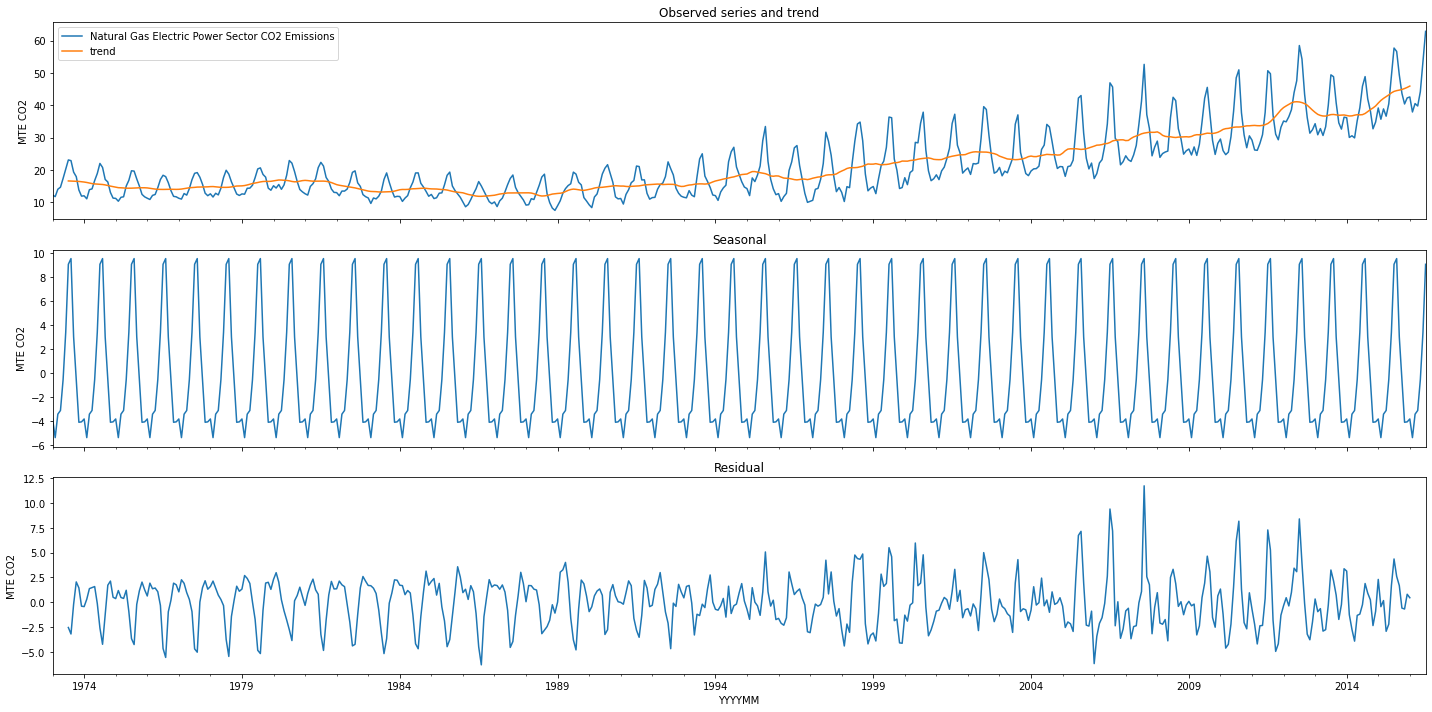


Analysing mte
-------------
Dickey-Fuller test results 
ADF Statistic: 	1.831
p-value: 	0.998
Lags used: 	19
Obvs used: 	503
Critical Values
	1%: -3.443
	5%: -2.867
	10%: -2.570
Series is non-stationary
Differnces reqd to make stationary: 1


In [7]:
#Importing the seasonal_decompose function to decompose the time series
# decompose the orinal time series

from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(mte)

fig, axes = plt.subplots(3, 1,figsize=(20,10), sharex=True)

axes[0].set_ylabel('MTE CO2')
axes[0].set_title ("Observed series and trend")
decomp.observed.plot(ax=axes[0], legend=True)
decomp.trend.plot(ax=axes[0], legend=True)

axes[1].set_ylabel('MTE CO2')
axes[1].set_title ("Seasonal")
decomp.seasonal.plot(ax=axes[1])

axes[2].set_ylabel('MTE CO2')
axes[2].set_title ("Residual")
decomp.resid.plot(ax=axes[2])

plt.tight_layout()
plt.show()

print ("\nAnalysing mte")
print ("-------------")

TestStationarityADF (mte)

## Observations:

1. There is a clear upward trend starting in 1994
2. There is obvious and consistent **annual** seasonality
3. Time series is not stationary and requires first order differencing 

In [8]:
# Make time-series stationary by first-order differencing

mte_dif = mte.diff()

# Remove the seasonal differnce 

mte_dif = mte.diff(12)

mte_dif.dropna(inplace=True)

TestStationarityADF (mte_dif)

Dickey-Fuller test results 
ADF Statistic: 	-4.412
p-value: 	0.000
Lags used: 	13
Obvs used: 	497
Critical Values
	1%: -3.444
	5%: -2.867
	10%: -2.570
Series is stationary




Now the time series is stationary - we can start to determine 

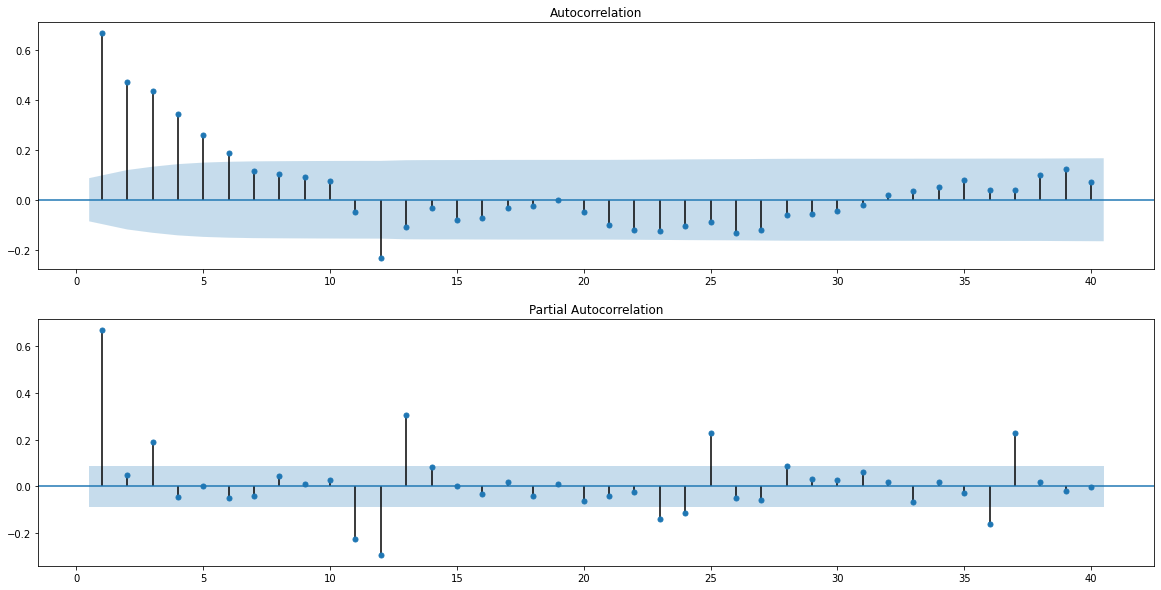

In [9]:
# Plot (P)ACF using log transformed and shifted data
# to find p & q

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

nlags = 40

fig, ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(mte_dif, lags=nlags, ax=ax[0], zero=False)
plot_pacf(mte_dif, lags=nlags, ax=ax[1], zero=False)

plt.show()

##Observations:

**Note : the above ACF and PACF charts start at lag-1**

For ACF - there is a gradually decreasing trend 
For PACF - cuts after lag-1

This suggests AR(1) would be appropriate.

#Modelling

## Train / Test Split
At this point we need to split out the training and testing data.

* mte = training data 
* **mte_test** = testing data (last 2 years)

In [10]:
mte_test = mte[499:]
mte = mte[:499]

print ("Training Data :")
SummarizeDS(mte)

print ("Test Data :")
SummarizeDS(mte_test)


Training Data :
number of rows 499
invalid rows 0
time series range 01/1973 to 07/2014
Test Data :
number of rows 24
invalid rows 0
time series range 08/2014 to 07/2016


## SARIMA
The SARIMA model () is suitable as it is specifically designed for seasonal time series data. The general form of SARIMA is :

  SARIMA(p,d,q)x(P,D,Q)lag

Where 

* p and seasonal P: indicate the number of AR terms (lags of the stationary series)
* d and seasonal D: indicate differencing that must be done to stationary series
* q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)
* lag: indicates the seasonal length in the data

As a first order estimate we will build a model using:

  SARIMA (1,1,1)x(1,1,1)12




In [11]:
from pyparsing import results
# Function to plot model against time series and show summary results

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def EvalSARIMA (series, ppdq, pPDQs) :

  model=sm.tsa.statespace.SARIMAX(
          series,
          order=ppdq,
          seasonal_order=pPDQs,
          enforce_stationarity=False,
          enforce_invertibility=False)
    
  results = model.fit() #fit the model

  plt.figure(figsize=(16,8))
  plt.plot(series) 
  plt.plot(results.predict(), color='red')

  titletext = "SARIMA {p} {P} : MSE={mse:.3f}, AIC={aic:.3f}".format (
        p=ppdq, 
        P=pPDQs, 
        mse=mean_squared_error(results.fittedvalues,series, squared=False), 
        aic=results.aic)

  plt.title (titletext)

  plt.show()

  # Plot diagnostics
  results.plot_diagnostics(figsize=(16,10));
 

  return results  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


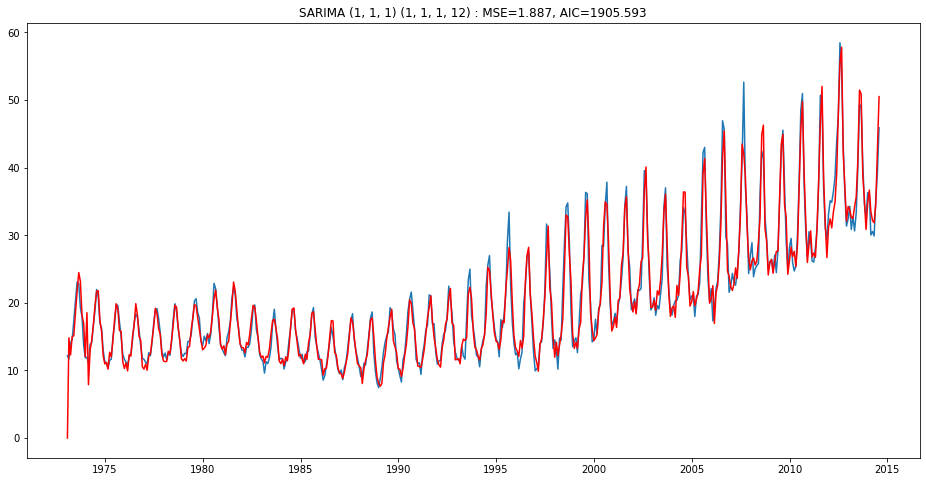

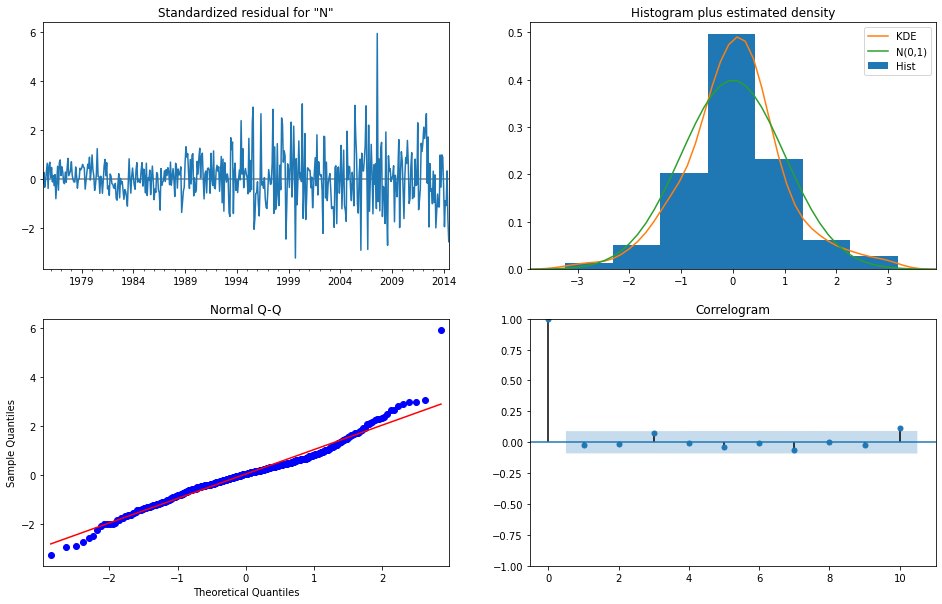

In [12]:
EvalSARIMA (mte,(1,1,1),(1,1,1,12))


## SARIMA Grid Search

While the first order approximation for SARIMA was good, we'll use a grid search to iterate through different combinations of ARIMA combinations to find the best AIC.

In [13]:
# Code inspired by : 
# https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b
#

warnings.filterwarnings("ignore") # specify to ignore warning messages

# non-seasonal p,d,q can take any value of 0, 1, 2
# note : a range > 2 will take significant time
# this code doesn't need to be run once we have the SARIMA inputs
p = d = q = range(0, 1) 
pdq = list(itertools.product(p, d, q)) 

#seasonal argument
s=12

# Generate all different combinations of seasonal P, D and Q triplets
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))] 

results = []

for param in pdq:
    for sparam in pdqs:

        try :
          mod = sm.tsa.statespace.SARIMAX(mte,
                                       order=param,
                                       seasonal_order=sparam,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
                                       
          fitres = mod.fit()
          tup = [param,sparam,fitres.aic]
          results.append (tup)
#          DEBUG
#          print ("SARMIMAX", tup)
        except Exception as e:
            print(e)
            continue


 # Convert into dataframe
topresults = pd.DataFrame(results, columns=['pdq', 'PDQs', 'AIC'])

# Sort and return top 3 combinations    
topresults = topresults.sort_values(by=['AIC'],ascending=True)[0:3]

print ( 'Top 3 models')
print (topresults)


Top 3 models
         pdq           PDQs          AIC
0  (0, 0, 0)  (0, 0, 0, 12)  4522.297059


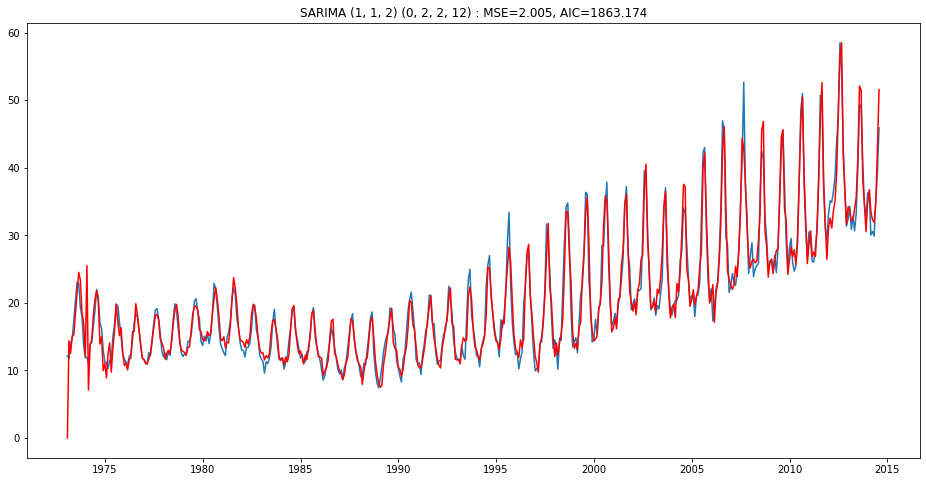

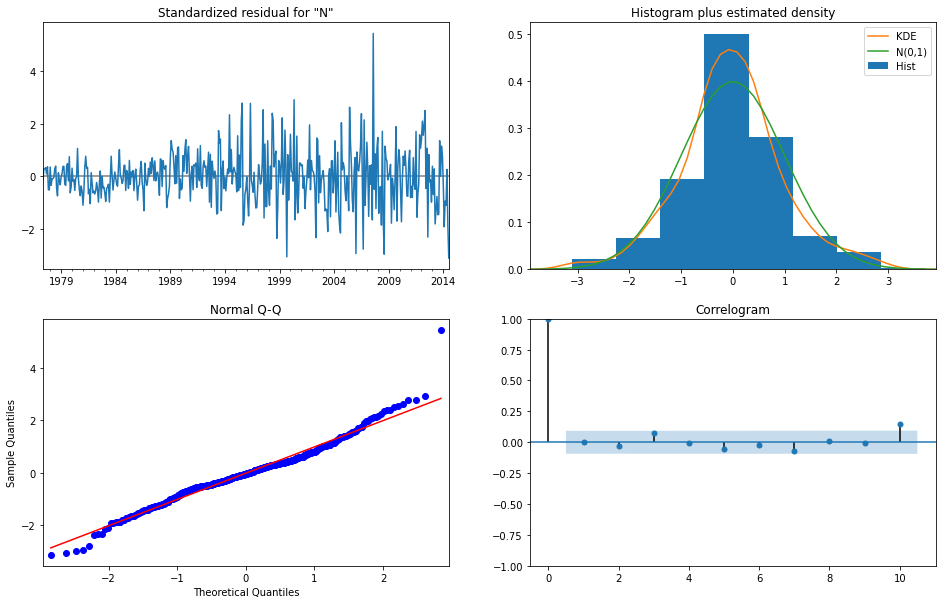

In [14]:
# Plot and evaluate the best model so we can compare it to our manual model

results = EvalSARIMA (mte,(1, 1, 2) , (0, 2, 2, 12))


## Model Evaluation

We will make some prediction within the time series data to determine how well the model is predicting the trend.

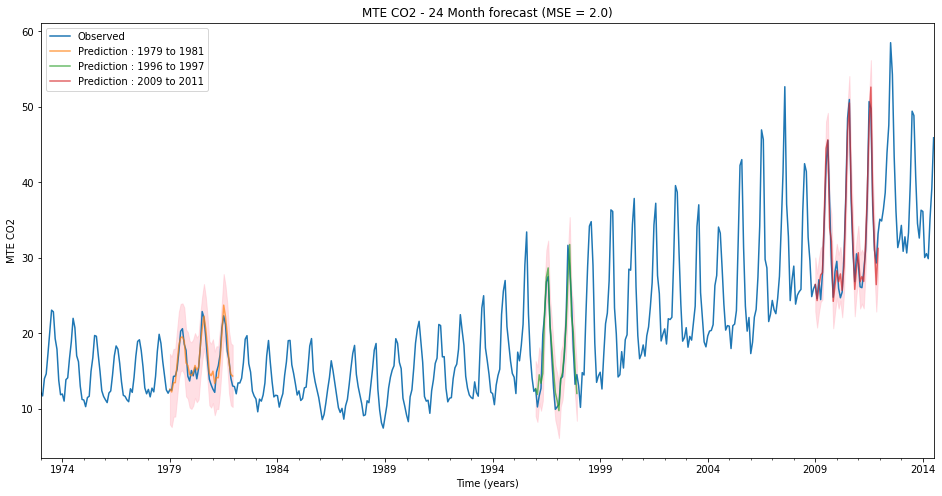

In [15]:


plt.figure(figsize=(16,8))

ax = mte.plot(label='Observed')
ax.set_xlabel('Time (years)')
ax.set_ylabel('MTE CO2')


# Compute the mean square error
mse=mean_squared_error(mte, results.fittedvalues, squared=False)

plt.title('MTE CO2 - 24 Month forecast (MSE = {})'.format(round(mse, 2)))

# Some random 2-year ranges to predict
preds = [['1979','1981'],
         ['1996','1997'],
         ['2009','2011']]

for start_date,end_date in preds :
  pr = results.get_prediction(start = start_date, end = end_date, dynamic=False)

  # Plot predictions with confidence intervals against known values

  pr_ci = pr.conf_int()
  pr_ci.head()

  label = "Prediction : {start} to {end}".format(start=start_date,end=end_date) 

  pr.predicted_mean.plot(ax=ax, label=label, alpha=.7)

  ax.fill_between(pr_ci.index,
                pr_ci.iloc[:, 0],
                pr_ci.iloc[:, 1], color='pink', alpha=.5)

plt.legend()

plt.show()

# Testing

Now lets see how the model does on the test data.

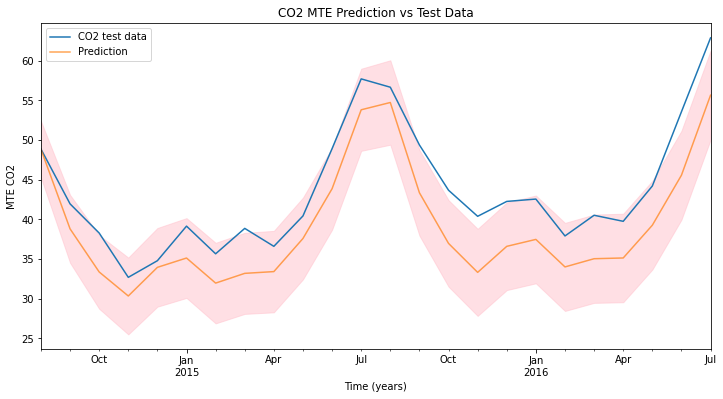

In [16]:
start=len(mte)
end=len(mte)+len(mte_test)-1

predictions = results.get_prediction(start=start, end=end, dynamic=False)

# Plot predictions with confidence intervals against known values

ax = mte_test.plot(legend=True,
                   figsize=(12,6),
                   label="CO2 test data",
                   title="CO2 MTE Prediction vs Test Data")

pr_ci = predictions.conf_int()
pr_ci.head()

predictions.predicted_mean.plot(ax=ax, label="Prediction", alpha=.7)

ax.fill_between(pr_ci.index,
                pr_ci.iloc[:, 0],
                pr_ci.iloc[:, 1], color='pink', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('MTE CO2')

plt.legend()

plt.show()

## Observations

The accuracy of the prediction on the test data is lower than the training data but still seems to be accurate enough to predict 12 months. 

# Forecasting

Now Let's Make some forecasts beyond the end of the data set.

In [17]:
# reconstitute the full data set from train and test sets
mte = mte.append(mte_test)

SummarizeDS(mte)

order = (1, 1, 2)
seasonal_order = (0, 2, 2, 12)

#create and fit model
model=sm.tsa.statespace.SARIMAX(
          mte,
          order=order,
          seasonal_order=seasonal_order,
          enforce_stationarity=False,
          enforce_invertibility=False)
    
final_results = model.fit()

 # Forecast 2 years or 24 months ahead
final_forecast = final_results.get_forecast(steps = 24)

# Get confidence intervals of forecasts
final_forecast_ci = final_forecast.conf_int()


number of rows 523
invalid rows 0
time series range 01/1973 to 07/2016


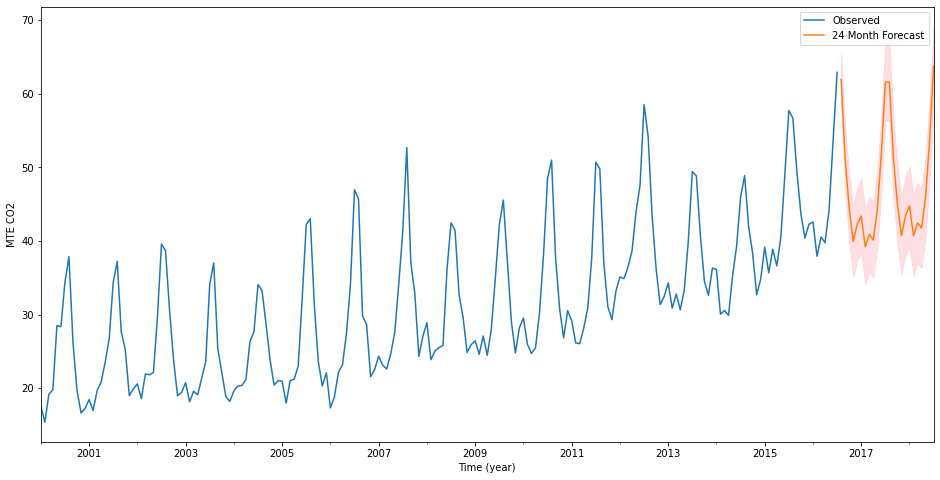

In [18]:
# Ignore dates up to 2000 in the plot so we can see the prediction more clearly

ax = mte['2000':].plot(label='Observed', figsize=(16, 8))

final_forecast.predicted_mean.plot(ax=ax, label='24 Month Forecast')

ax.fill_between(final_forecast_ci.index,
                final_forecast_ci.iloc[:, 0],
                final_forecast_ci.iloc[:, 1], color='pink', alpha=.5)

ax.set_xlabel('Time (year)')
ax.set_ylabel('MTE CO2')

plt.legend()
plt.show()

** Observations

The 24 Month forecast certainly looks credible (captures seasonailty and trend) but only time will tell.